In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
from core import bw_color_palette
from seaborn import axes_style
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
sys_height = 0.25

In [88]:
def get_df_q_cov(row):
    if not pd.isna(row['defense_homolog_names']):
        return 1
    elif not pd.isna(row['q_cov']):
        return row['q_cov']
    else:
        return 0

In [117]:
def plot_system(system_df, cat_domains, all_catalytic_df, show_scale=True, show_prob_cmap=False, 
                hhpred_cmap=None, sys_height=sys_height, clip_on=False):
    sys_height += -0.05
    if hhpred_cmap is None:
        hhpred_cmap = sns.color_palette("light:#E8020B", as_cmap=True)
    total_length = system_df['product_length'].sum() + 3*len(system_df)
    fig, ax = plt.subplots(figsize=(3.9, sys_height))
    ax.set_clip_on(clip_on)
    x_offset = 0
    if system_df['strand'].to_list()[0] == '-':
        system_df = system_df.sort_values('start', ascending=False).reset_index(drop=True)
    else:
        system_df = system_df.sort_values('start', ascending=True).reset_index(drop=True)
    for _, protein_series in system_df.iterrows():
        product_accession = protein_series['product_accession']
        protein_length = protein_series['product_length']
        protein_edgecolor = 'black'
        # plot individual domains
        domain_df = cat_domains[cat_domains['product_accession'] == product_accession]
        for _, domain_series in domain_df.iterrows():
            textcolor='black'
            start = domain_series['start']
            end = domain_series['end']
            label = domain_series['Domain Name']
            probability = domain_series['Domain Prob']
            if not pd.isnull(probability):
                color = hhpred_cmap(probability)                   
            else:
                color = 'darkgrey'
            domain_rect = patches.Rectangle((x_offset + start, -3), end - start, 6, facecolor=color, linewidth=0, clip_on=clip_on)
            ax.add_patch(domain_rect)
            ax.text(x_offset + ((start + end) / 2), -0.3, label, ha='center', va='center', fontdict={'color': textcolor})
        catalytic_df = all_catalytic_df[all_catalytic_df['Target Product'] == product_accession]
        for _, row in catalytic_df.iterrows():
            residue = row['Target Residue']
            ax.plot(x_offset + residue, 2, 'v', clip_on=clip_on, color='black', markersize=5, linewidth=0)
        arrow_width = 6
        protein_arrow = patches.FancyArrow(x_offset, 0, protein_length, 0, 
                                           width=arrow_width, facecolor='none', edgecolor=protein_edgecolor, linewidth=1, 
                                           length_includes_head=True, head_width=arrow_width, head_length=0.05*total_length, 
                                           clip_on=clip_on)
        ax.add_patch(protein_arrow)
        #if protein_series['df_q_cov'] > 0.5:
        #    ax.text(x_offset + protein_length - 0.02*total_length, 2.8, '*', ha='center', va='center', fontdict={'color': 'black'})
        x_offset += protein_length + 3
    ax.axis('off')
    if show_scale: 
        ax.hlines(-4, 0, 100, linewidth=1, color='black', zorder=0, clip_on=clip_on)
    if show_prob_cmap:
        # Add a colorbar legend
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="150%", )
        norm = plt.Normalize(0, 1)
        cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=hhpred_cmap), cax=cax, orientation='horizontal', 
                          fraction=0.046, pad=0.04)
        cb.set_label("HHPred Probability")

In [8]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7

In [9]:
cat_eop_df = pd.read_csv('../data/raw/Catalytic mutant EOP tracking - System EOPs.csv')
eop_df = pd.read_csv('../data/raw/24-03-28 EOP tracking - Systems.csv')
mutant_name_df = pd.read_csv('../data/raw/Catalytic mutant EOP tracking - System Display Names.csv')
systems_df = pd.read_csv('../data/raw/Beaker validation domains - hit_proteins.csv')
domains_df = pd.read_csv('../data/raw/Beaker validation domains - hhpred_domains.csv')
tm_df = pd.read_csv('../data/raw/Beaker validation domains - tm.csv')
cc_df = pd.read_csv('../data/raw/Beaker validation domains - coiled_coil.csv')

In [10]:
cat_domains = pd.concat([domains_df, 
                         tm_df, 
                         cc_df])

## Plot EOP changes

In [11]:
eop_df['Background strain'] = 'MG1655'
merged_eop_df = (pd.concat([cat_eop_df, eop_df])
                 .merge(mutant_name_df, how='inner', on=['Background strain','System','Catalytic mutant']))
merged_eop_df['Display name'] = pd.Categorical(merged_eop_df['Display name'], 
                                               categories=mutant_name_df['Display name'])
merged_eop_df['smaller_plaque'] = (merged_eop_df['Smaller Plaque Size'] == 'Y').fillna(False)

In [12]:
eop_delta_df = (merged_eop_df.groupby(['Display name', 'Phage'])
                .agg(delta=('-log(EOP)', lambda x: (x - x.mean()).abs().sum()))
                .reset_index()
                .sort_values('delta', ascending=False))

In [13]:
eop_delta_df.head(10)

,Display name,Phage,delta
177,MLPD-3,Bas60,4.782771
537,MLPD-P2,Bas60,3.120827
216,CBASS V,Bas1,2.799715
46,∆Capsule MLPD-M1,T5,2.683730
443,MLPD-H1 + GNAT,Bas67,2.480106
7,MLPD-M1,Bas50,2.216341
712,MLPD-P1,RB69,2.077323
120,HipAD,Bas1,1.981314
38,∆Capsule MLPD-M1,Candy,1.853872
31,∆Capsule MLPD-M1,Bas50,1.823909


In [119]:
def plot_eop(top_eop_df, top_phage):
    plt.subplots(figsize=(2, 0.17*top_eop_df['Display name'].nunique()))
    sns.scatterplot(data=top_eop_df, y='Display name', x='-log(EOP)', alpha=0.8, 
                color='black', s=50, clip_on=False, zorder=2, marker='.', linewidth=0)
    sns.barplot(data=top_eop_df, y='Display name', x='-log(EOP)', 
                errorbar=None, color='#ffff99', clip_on=False, zorder=1, 
                fill=True, edgecolor='black', linewidth=0.5)
    sns.despine()
    plt.ylabel('')
    plt.xlabel('-log(EOP) vs. ' + top_phage)
    plt.axvline(x=0, linestyle='dashed', color='black', zorder=0, linewidth=0.5)
    

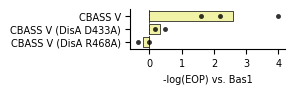

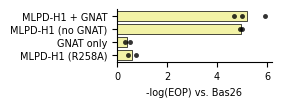

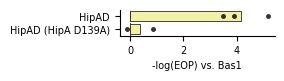

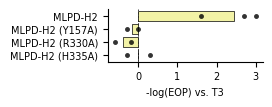

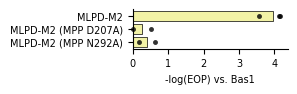

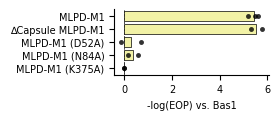

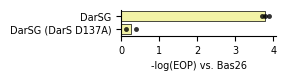

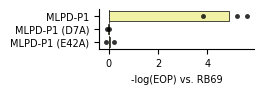

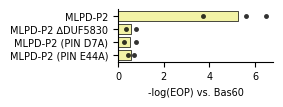

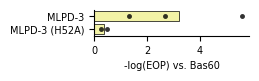

In [120]:
for system, system_df in merged_eop_df.groupby('System'):
    system_df['Display name'] = system_df['Display name'].cat.remove_unused_categories()
    top_phage = (system_df.sort_values('-log(EOP)', ascending=False)
               .head(1)
               .squeeze()
               ['Phage'])
    top_eop_df = system_df[system_df['Phage'] == top_phage]
    plot_eop(top_eop_df, top_phage)
    plt.savefig('../figures/' + system + '_v_' + top_phage + '_catalytic_eop.svg', dpi=300, bbox_inches='tight')

## Plot residues of mutations

In [89]:
systems_df['df_q_cov'] = systems_df.apply(get_df_q_cov, axis=1)

In [91]:
filtered_system_df = systems_df[systems_df['working_id'].isin(mutant_name_df['System'].drop_duplicates().to_list())]
filtered_system_df['working_id'].nunique()                                                                                

10

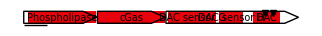

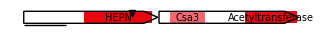

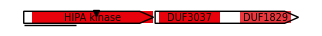

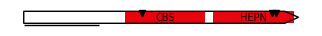

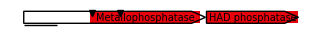

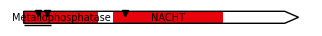

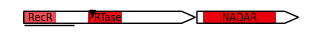

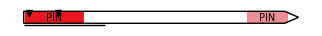

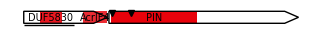

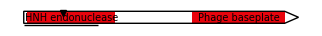

In [118]:
for system, system_df in (filtered_system_df
                          .sort_values(['working_id', 
                                        'protein_num'])
                          .groupby('working_id')):
    plot_system(system_df, cat_domains, mutant_name_df)
    plt.savefig('../figures/hit_system_' + system + '_mutated_residues.svg', dpi=300, bbox_inches='tight')